# Processing Data


In [1]:
# ruff: noqa: E402

%load_ext autoreload
%autoreload 2

# find the root of the project
import os
from pathlib import Path
import sys
import polars as pl
import dotenv


ROOT = Path(os.getcwd()).parent
while not ROOT.joinpath(".git").exists():
    ROOT = ROOT.parent

# add the root to the python path
sys.path.append(str(ROOT))


dotenv.load_dotenv(ROOT.joinpath(".env"))

from src.utils import check_gpu_available

GPU = check_gpu_available()
print(f"GPU available: {GPU}")

/home/max/Development/roadside-radar/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU available: True


## Load the Network


In [2]:
import geopandas as gpd
from src.geometry import RoadNetwork


mainline_net = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    keep_lanes=["EBL1", "WBL1"],
    step_size=0.01,
)

full_net = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    keep_lanes=None,
    step_size=0.01,
)

LANE_WIDTH = 3.55
LANE_NUM = 2

## Read in the Trajectories


In [3]:
print(os.environ.get("RAW_DATA_DIR"))

/media/HDD/max/radar-data


In [4]:
veh_df = (
    pl.read_csv(
        ROOT / "data" / "vehicle_drives" / "2023-10-31.csv",
    )
    .drop("")
    .with_columns(
        pl.col("gps_time").str.strptime(
            dtype=pl.Datetime(
                time_unit="us",
            ),
        ),
    )
    # .sort(
    #     "gps_time",
    # )
    # # .with_row_count(name="seq")
)

In [5]:
from datetime import timedelta
import polars as pl
from src.radar import CalibratedRadar
from src.pipelines.open_file import prep_df


USE_FRONT = False


radar_obj = CalibratedRadar(
    radar_location_path=ROOT / "configuration" / "october_calibrated.yaml",
)


radar_df = (
    pl.scan_parquet(
        Path(os.environ.get("RAW_DATA_DIR")).joinpath("*.parquet"),
        # Path(os.environ.get("RAW_DATA_DIR")).joinpath("1698774489178.parquet"),
    )
    .with_columns(
        pl.col("epoch_time").dt.replace_time_zone("UTC"),
    )
    .with_context(veh_df.lazy())
    .filter(
        pl.col("epoch_time").is_between(
            pl.col("gps_time").min() - timedelta(minutes=2),
            pl.col("gps_time").max() + timedelta(minutes=2),
        )
    )
    .with_columns(
        (pl.col("f32_positionX_m") ** 2 + pl.col("f32_positionY_m") ** 2)
        .sqrt()
        .alias("dist"),
    )
    .filter(
        pl.when(pl.col("ip").is_in(["10.160.7.141", "10.160.7.137"]))
        .then(pl.col("dist") < 300)
        .otherwise(pl.lit(True))
    )
    .collect()
    .lazy()
    .pipe(prep_df, f=radar_obj)
    .collect()
    .pipe(
        mainline_net.map_to_lane,
        dist_upper_bound=LANE_WIDTH * LANE_NUM
        - (LANE_WIDTH / 2)
        + 0.5,  # centered on one of the lanes,
        utm_x_col="utm_x",
        utm_y_col="utm_y",
    )
    .filter(pl.col("name").is_not_null())
    .rename(
        {
            "name": "lane",
            "angle": "heading_lane",
        }
    )
)

function: create_object_id took: 0.00021576881408691406 seconds
function: filter_short_trajectories took: 0.00032639503479003906 seconds
function: clip_trajectory_end took: 0.0002079010009765625 seconds
function: resample took: 0.00022292137145996094 seconds
function: fix_duplicate_positions took: 0.00013494491577148438 seconds
function: set_timezone took: 4.673004150390625e-05 seconds
function: add_cst_timezone took: 2.9325485229492188e-05 seconds
function: add_heading took: 2.8848648071289062e-05 seconds
function: rotate_radars took: 0.00046634674072265625 seconds
function: update_origin took: 0.0004703998565673828 seconds


### Save Shenglin's Data

In [6]:
# save_df = (
#     radar_df.filter(pl.col("ip").str.contains("142") | pl.col("ip").str.contains("141"))
#     .select(
#         [
#             "epoch_time_cst",
#             "object_id",
#             "utm_x",
#             "utm_y",
#             pl.col("f32_velocityInDir_mps").alias("speed"),
#             "ip",
#             "f32_length_m",
#             "f32_distanceToFront_m",
#             "f32_distanceToBack_m",
#             "heading",
#         ]
#     )
#     .filter(
#         pl.col("epoch_time_cst").is_between(
#             pl.lit("2023-10-31 11:58:00").str.strptime(
#                 pl.Datetime(time_unit="ns", time_zone="US/Central"),
#             ),
#             pl.lit("2023-10-31 13:02:00").str.strptime(
#                 pl.Datetime(time_unit="ns", time_zone="US/Central"),
#             ),
#         )
#     )
# )

# save_df.write_csv('/home/max/Development/roadside-radar/data/10_31_2023_12_13.csv')

In [7]:
from src.pipelines.kalman_filter import (
    prepare_frenet_measurement,
    build_extension,
    add_timedelta,
    build_kalman_id,
    filter_short_trajectories,
)


prediction_length = 4

print(radar_df.shape)

radar_df = (
    radar_df.pipe(add_timedelta, vehicle_id_col=["object_id", "lane"])
    .pipe(build_kalman_id, split_time_delta=prediction_length + 0.1)
    .pipe(filter_short_trajectories, minimum_distance_m=5, minimum_duration_s=2)
    .pipe(prepare_frenet_measurement)
    .pipe(build_extension, seconds=prediction_length)
    .pipe(add_timedelta)
    .collect()
)

print(radar_df.shape)

(874463, 38)
function: add_timedelta took: 0.00021147727966308594 seconds
function: build_kalman_id took: 0.0002963542938232422 seconds
function: filter_short_trajectories took: 0.00022339820861816406 seconds
function: prepare_frenet_measurement took: 0.0004780292510986328 seconds
function: build_extension took: 1.245089054107666 seconds
function: add_timedelta took: 0.00010418891906738281 seconds
(1140519, 52)


In [8]:
# radar_df_tmp.filter(
#     pl.col("object_id") == 326376547316693
# )

In [9]:
# test_df['epoch_time'].dt.min(), test_df['epoch_time'].max()

In [10]:
# import plotly.graph_objects as go
# from src.plotting.time_space import plot_time_space
# from datetime import timedelta


# fig = go.Figure()

# # get a 10 minute window
# plot_df = (
#     radar_df
#     .with_columns((pl.col("s") + pl.col('distanceToFront_s')).alias("s"))
#     .pipe(radar_obj.add_cst_timezone)
#     .filter(
#     #     pl.col("epoch_time_cst").is_between(
#     #         pl.lit("2023-03-13 06:50:00").str.strptime(pl.Datetime(time_unit="ns", time_zone='US/Central'), ),
#     #         pl.lit("2023-03-13 06:59:00").str.strptime(pl.Datetime(time_unit="ns", time_zone='US/Central'), ),
#     #     )
#         (pl.col("lane").str.contains("E"))
#         # & (pl.col("lane_index") == 0)
#     )
#     .with_columns(
#         (pl.col('s').max() - pl.col('s')).alias('s'),
#     )
#     # .filter(pl.col("vehicle_id") == 886)
# )

# fig = plot_time_space(
#     plot_df,
#     hoverdata="object_id",
#     vehicle_col="object_id",
#     s_col="s",
#     markers=True,
#     fig=fig,
# )

# fig.update_layout()


# fig.show()

In [11]:
# radar_df[["s", "s_velocity", "d", "d_velocity"]].describe()

In [12]:
from src.pipelines.kalman_filter import build_kalman_df

filter_df = (
    radar_df
    # .with_columns((pl.col("distanceToFront_s") + pl.col("s")).alias("front_s"))
    .pipe(build_kalman_df, s_col="front_s" if USE_FRONT else "s", derive_s_vel=False)
    .filter(
        pl.col("max_time") < pl.col("max_time").max()  # filter out the outlier times
    )
    .collect()
)

function: build_kalman_df took: 0.0006821155548095703 seconds


### IMM Filter the Radar Trajectories


In [13]:
filter_df.group_by("vehicle_ind").agg(pl.col("time_ind").max())["time_ind"].describe()

shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 7902.0     │
│ null_count ┆ 0.0        │
│ mean       ┆ 143.216907 │
│ std        ┆ 75.580931  │
│ min        ┆ 38.0       │
│ 25%        ┆ 99.0       │
│ 50%        ┆ 130.0      │
│ 75%        ┆ 165.0      │
│ max        ┆ 861.0      │
└────────────┴────────────┘

In [14]:
from src.filters.vectorized_kalman import batch_imm_df
import numpy as np

filt_df = batch_imm_df(
    filter_df.rename({"measurement": "z"}),
    filters=("CALC", "CALK", "CVLK"),
    M=np.array([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]]),
    mu=np.array([0.1, 0.1, 0.8]),
    # chunk_size=3_500,
    chunk_size=100_000 if not GPU else 10_000 * 1000,
    gpu=GPU,
)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:24<00:00, 24.20s/it]


In [15]:
from src.pipelines.kalman_filter import join_results

joined_df = join_results(filt_df, filter_df, radar_df)

if USE_FRONT:
    joined_df = joined_df.rename({"s": "front_s"})

joined_df = joined_df.collect()

function: join_results took: 0.0007998943328857422 seconds


In [16]:
joined_df.shape

(1139602, 61)

### Tuning the IMM Filter Noise Parameters

In [17]:
# from src.filters.fusion import mahalanobis_distance
# from scipy.stats import chi2

# target = chi2.ppf(0.95, 4)


# test_df = (
#     joined_df.lazy()
#     .with_columns(
#         pl.col(
#             "s",
#             "s_velocity",
#             "d",
#             "d_velocity",
#         )
#         .shift(1)
#         .backward_fill(1)
#         .over("object_id")
#         .name.map(lambda x: x + "_leader"),
#         pl.col("P")
#         .cast(pl.List(inner=pl.Float32))
#         .shift(1)
#         .backward_fill(1)
#         .over("object_id")
#         .cast(joined_df["P"].dtype)
#         .name.map(lambda x: x + "_leader"),
#     )
#     .collect()
#     .pipe(
#         mahalanobis_distance,
#         return_maha=True,
#         pos_override=["s"],
#         gpu=GPU,
#     )
# ).select(["m_sq"])

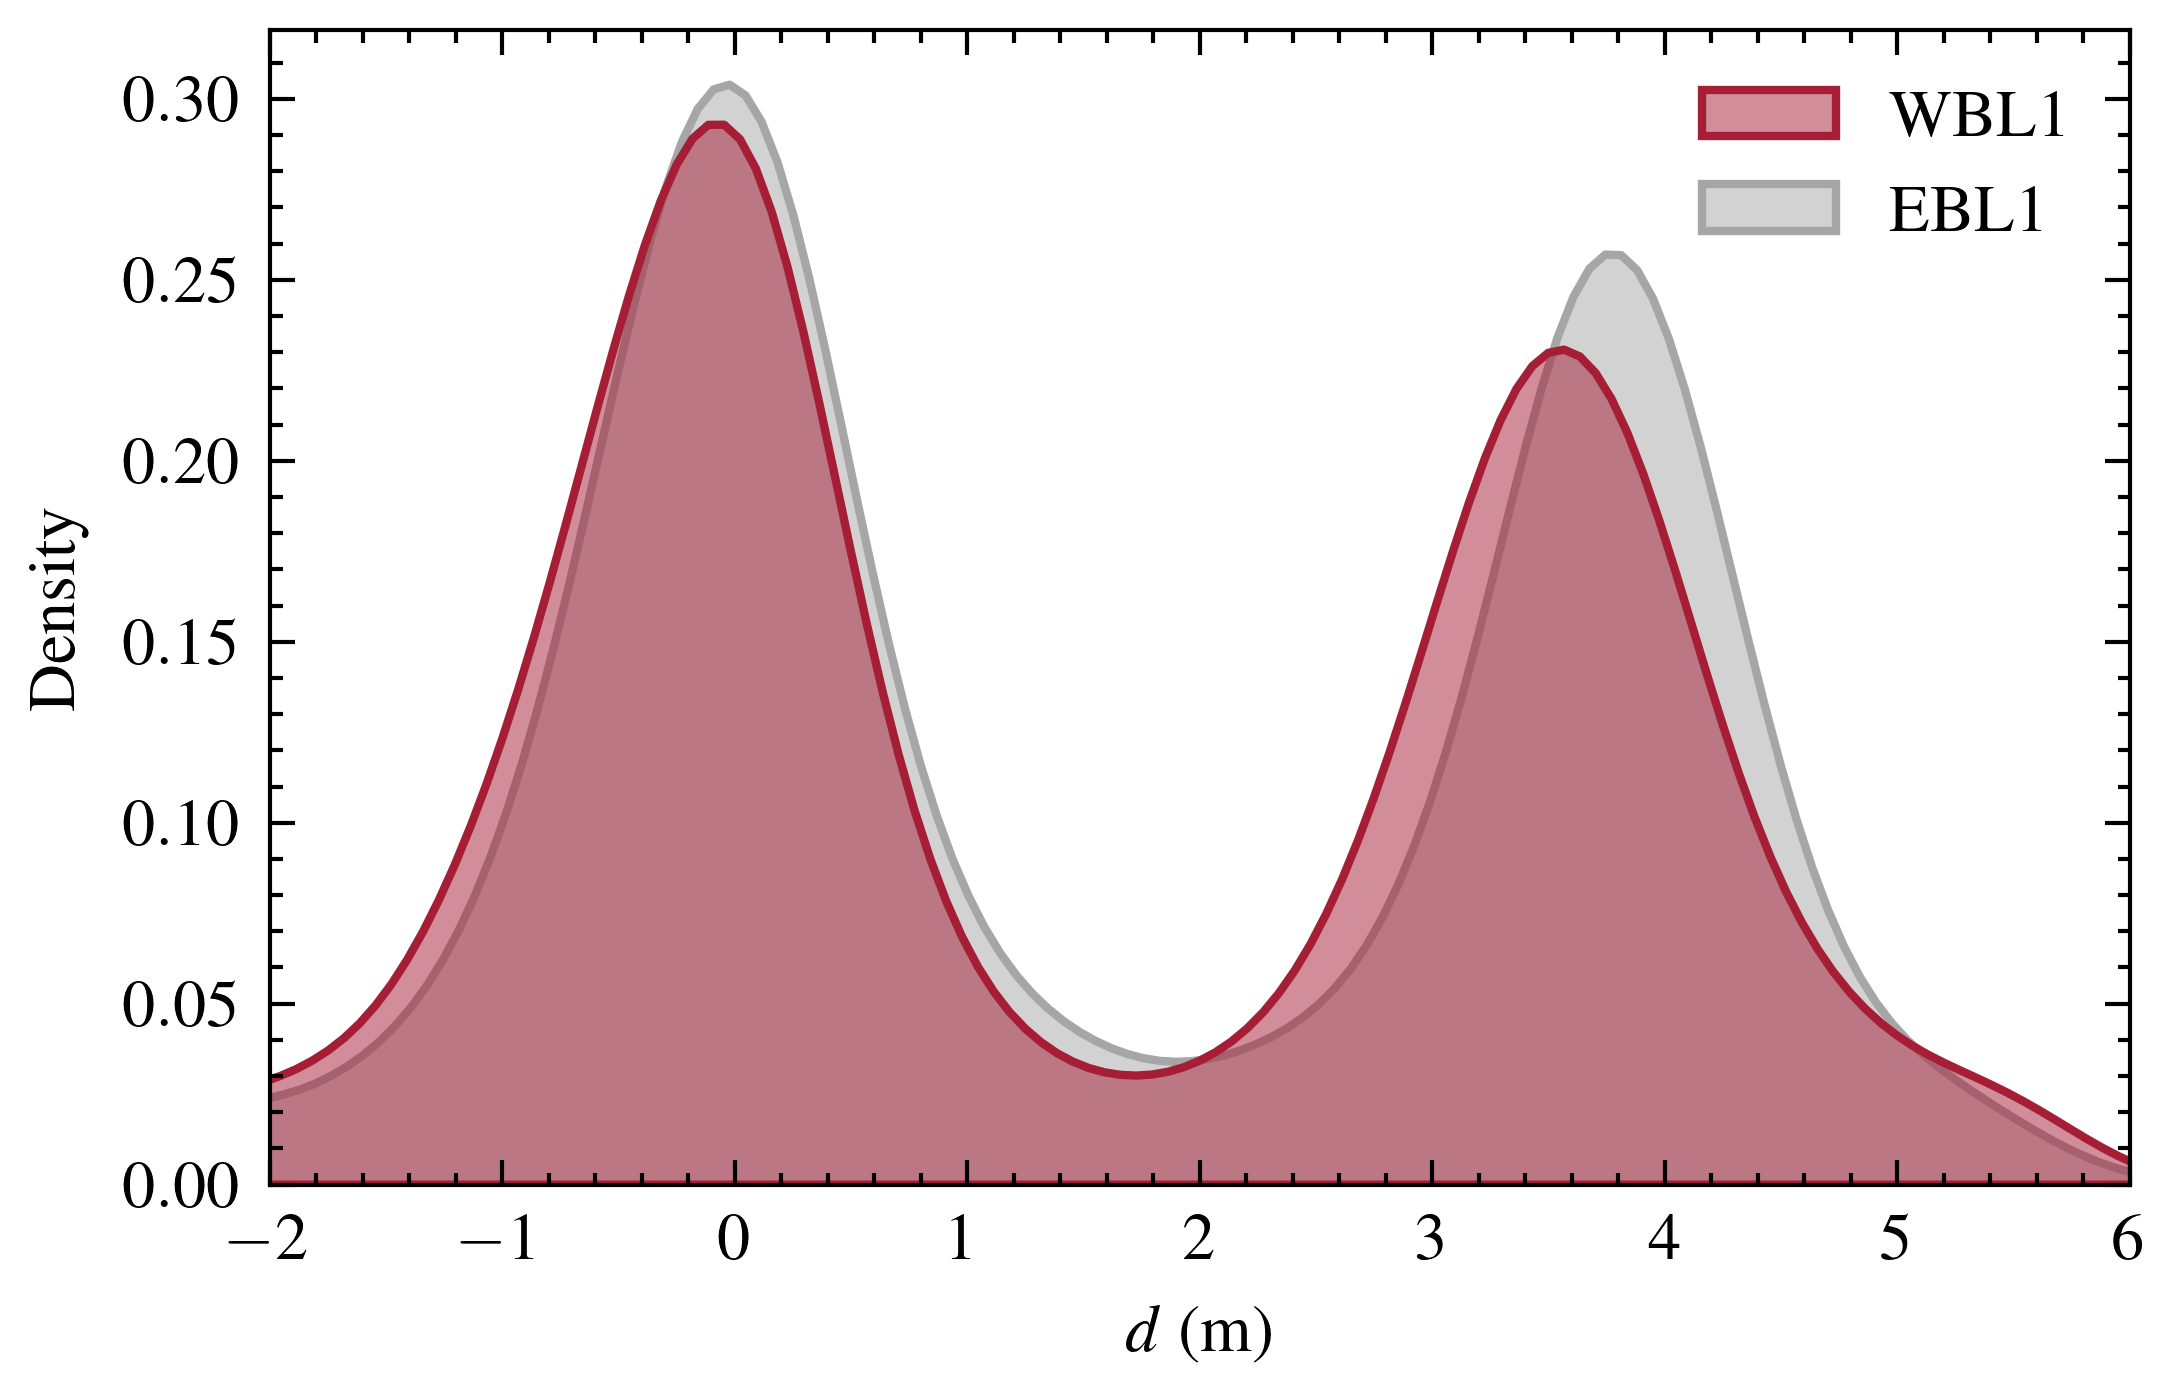

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

engine_color = [0.65, 0.65, 0.65]
gps_color = [0, 0, 0.75]
plutron_color = [0, 0, 0]
alabama = [165, 30, 54]
alabama = [i / 255 for i in alabama]

plt.style.use(["science", "ieee"])

fig, ax = plt.subplots(
    figsize=(4, 2.5),
)

# create a kde plot of the d dimension in both directions
lane_df = (
    joined_df.select(
        [
            "lane",
            "d",
        ]
    )
    .melt(id_vars="lane", value_name="d")
    .filter(pl.col("d").is_between(-6, 6))
    .sample(100_000)
)


lane_df = lane_df.to_pandas()

sns.kdeplot(
    data=lane_df,
    x="d",
    hue="lane",
    fill=True,
    common_norm=False,
    alpha=0.5,
    ax=ax,
    linewidth=1,
    palette=[alabama, engine_color],
)

ax.set_xlim(-2, 6)

ax.set_xlabel("$d$ (m)")
# remove the title of the legend
ax.get_legend().set_title("")

# st th

### Classify the Lanes


In [19]:
from src.pipelines.lane_classification import label_lane, label_lanes_tree
from src.gmm.lane_classification import build_lane_model
from src.plotting.lane_gmm import plot_model

In [20]:
joined_df = joined_df.pipe(
    label_lanes_tree,
    full_network=full_net,
    kalman_network=mainline_net,
    lane_width=LANE_WIDTH,
    s_col="front_s" if USE_FRONT else "s",
)


print(joined_df.filter(pl.col("lane_index").is_null()).shape[0] / joined_df.shape[0])

joined_df = joined_df.with_columns(pl.col("lane_index").fill_null(2))

0.10591153753678915


## Save the Kalman Filtered Trajectories

In [21]:
from src.pipelines.association import build_leader_follower_df, add_front_back_s

save_df = joined_df.select(
    [
        "epoch_time",
        "object_id",
        pl.col("s").alias("centroid_s"),
        (pl.col("s") + pl.col("distanceToFront_s")).alias("front_s"),
        (pl.col("s") + pl.col("distanceToBack_s")).alias("back_s"),
        "s_velocity",
        "d",
        "d_velocity",
        "lane",
        "lane_index",
        "prediction",
        "missing_data",
    ]
).clone()


# add x/y as calculated by the Frenet Transform
transformations = [
    ("front_s", "d", "front_x", "front_y"),
    ("back_s", "d", "back_x", "back_y"),
    ("centroid_s", "d", "centroid_x", "centroid_y"),
]

for s_col, d_col, x_col, y_col in transformations:
    save_df = (
        save_df.pipe(
            mainline_net.frenet2xy,
            lane_col="lane",
            s_col=s_col,
            d_col=d_col,
        )
        .drop(["s", "angle"])
        .rename({"x_lane": x_col, "y_lane": y_col})
    )


save_df.write_parquet(
    ROOT.joinpath("data", "october_kalman_2d_meas.parquet"),
)

## Merge the Trajectories


In [22]:
from src.pipelines.association import (
    build_leader_follower_df,
    add_front_back_s,
    build_leader_follower_entire_history_df,
)

joined_df = (
    joined_df.lazy()
    .pipe(
        add_front_back_s,
        use_global_median=True,
    )
    .sort(by=["epoch_time"])
    .set_sorted(["epoch_time"])
    .collect(streaming=True)
)

lf_df = (
    joined_df.lazy().pipe(
        build_leader_follower_entire_history_df,
        s_col="front_s" if USE_FRONT else "s",
        use_lane_index=True,
        max_s_gap=0.5 * 25,  # max headway of 0.5 seconds at 25 m/s
    )
    # .filter(~(pl.col("prediction") & pl.col("prediction_leader")))
    # .filter(pl.col("lane_index") <= 1)
    .filter((pl.col('s_velocity') > 0.5) & (pl.col('s_velocity_leader') > 0.5))
    .collect(streaming=True)
)

function: add_front_back_s took: 0.002979755401611328 seconds


function: lazy_func took: 0.000637054443359375 seconds


In [23]:
# lf_df

In [24]:
# lf_df.filter(
# (    pl.col("object_id").is_in(plot_df.filter(pl.col("vehicle_id") == 451)["object_id"])
#     & pl.col("leader").is_in(plot_df.filter(pl.col("vehicle_id") == 2809)["object_id"]))

# ).select(['s', 'front_s', 'back_s', 's_leader', 'front_s_leader', 'back_s_leader', 'd', 'd_leader', 'association_distance', 'P'])

### Calculate the Association Log-Likelihood Distance


In [63]:
from src.pipelines.association import calc_assoc_liklihood_distance

dims = 4

lf_df = lf_df.pipe(calc_assoc_liklihood_distance, gpu=GPU, dims=dims, permute=True)

function: lazy_func took: 2.102081537246704 seconds


### Calculate the Match Indexes


In [26]:
from scipy.stats import chi2
from src.pipelines.association import (
    calculate_match_indexes,
    pipe_gate_headway_calc,
    build_match_df,
    # filter_bad_lane_matches,
)

# prediction_length = 4

assoc1_df = (
    lf_df
    # is this really necessary? Just filters the match for a certain tome
    .pipe(calculate_match_indexes, min_time_threshold=1)
    .pipe(
        pipe_gate_headway_calc,
        window=20,
        association_dist_cutoff=chi2.ppf(0.99, dims),
    )
    .collect(streaming=True)
)

function: lazy_func took: 0.000339508056640625 seconds
function: lazy_func took: 0.000240325927734375 seconds


In [27]:
# # make a contour plot of the association distance vs the headway
# import matplotlib.pyplot as plt
# import matplotlib


# fig, ax = plt.subplots(figsize=(4, 2.5))

# assoc1_df.filter(
#     pl.col("headway").is_between(-5, 2)
#     & pl.col("association_distance_filt").is_between(-5, 30)
# )[["headway", "association_distance_filt"]].to_pandas().plot.hexbin(
#     x="headway",
#     y="association_distance_filt",
#     ax=ax,
#     gridsize=100,
#     norm=matplotlib.colors.LogNorm(),
# )


# # add a horizontal line at the 95th percentile of the chi squared distribution
# ax.axhline(chi2.ppf(0.99, dims), color="r", linestyle="--")

# # # set the y axis range
# # ax.set_ylim(-5, 10)

# # add a vertical line at headway cutoff of 0.5
# ax.axvline(0.5, color="r", linestyle="--")

In [28]:
match_df = (
    assoc1_df.lazy()
    .pipe(
        build_match_df,
        traj_time_df=joined_df.group_by("object_id")
        .agg(
            pl.col("epoch_time").max().alias("epoch_time_max"),
        )
        .lazy(),
        assoc_cutoff=chi2.ppf(0.95, dims),
        assoc_cutoff_pred=chi2.ppf(0.95, dims),
        time_headway_cutoff=0.01,
    )
    .collect(streaming=True)
)


# 1 - 0.99

function: lazy_func took: 0.01877284049987793 seconds


In [29]:
# assoc1_df

### Re-Label the Joined Trajectories


In [30]:
from src.pipelines.association import create_vehicle_ids
import networkx as nx
from itertools import combinations
from networkx.algorithms.connectivity import (
    node_connectivity,
    all_pairs_node_connectivity,
)

cc, G, assoc_df = joined_df.pipe(
    create_vehicle_ids,
    match_df,
)


def get_ordered_combinations(cc_list):
    return [
        (int(start), int(end), veh_i) if start < end else (end, start, veh_i)
        for veh_i, cc_list in enumerate(cc)
        for start, end in combinations(cc_list, 2)
    ]

function: lazy_func took: 0.044352054595947266 seconds
function: lazy_func took: 0.05589628219604492 seconds


In [31]:
need2_filt_ids = (
    assoc_df.with_columns(pl.count().over(["epoch_time", "vehicle_id"]).alias("count"))
    .filter(pl.col("count").max().over("vehicle_id") > 2)["vehicle_id"]
    .unique()
)

In [32]:
begin_end_df = joined_df.group_by("object_id").agg(
    pl.col("epoch_time").min().alias("begin_time"),
    pl.col("epoch_time").max().alias("end_time"),
)

combs = get_ordered_combinations(cc)

permute_df = (
    pl.DataFrame(
        combs,
        schema={"start": pl.UInt64, "end": pl.UInt64, "vehicle_index": pl.Int64},
    )
    .filter(pl.col("vehicle_index").is_in(need2_filt_ids))
    .join(begin_end_df.rename({"object_id": "start"}), on="start", how="left")
    .join(
        begin_end_df.rename({"object_id": "end"}),
        on="end",
    )
    # filter for overlap in time
    .filter(
        pl.min_horizontal(pl.col("end_time"), pl.col("end_time_right"))
        > pl.max_horizontal(pl.col("begin_time"), pl.col("begin_time_right"))
    )
    .with_columns(
        # sort the object id and leader
        pl.when(pl.col("start") < pl.col("end"))
        .then(pl.concat_list([pl.col("start"), pl.col("end")]))
        .otherwise(pl.concat_list([pl.col("end"), pl.col("start")]))
        .alias("pair")
    )
    .with_columns(pl.col("pair").hash().alias("pair_hash"))
    .with_columns(
        pl.concat_str(
            [pl.col("pair").list.get(0), pl.col("pair").list.get(1)], separator="-"
        ).alias("pair_str")
    )
    .with_columns(
        pl.lit(None, dtype=pl.Float64).alias("association_distance_filt"),
    )
    # .join(
    #     match_df.with_columns(
    #         pl.concat_str(
    #             [pl.col("pair").list.get(0), pl.col("pair").list.get(1)], separator="-"
    #         ).alias("pair_str")
    #     ).select(['pair_str', 'association_distance_filt']),
    #     on='pair_str',
    #     how='left'
    # )
)

In [33]:
need2compute = permute_df.filter(pl.col("association_distance_filt").is_null()).select(
    "start", "end", "pair_hash", "vehicle_index"
)

cols = [
    pl.col("object_id"),
    "epoch_time",
    "s",
    "lane",
    "d",
    "s_velocity",
    "d_velocity",
    "front_s",
    "back_s",
    "P",
    "prediction",
]

need2compute = (
    need2compute.lazy()
    .join(
        joined_df.lazy()
        # .filter((pl.col("lane_index") < 2))
        .select(cols).rename({"object_id": "start"}),
        on="start",
    )
    .join(
        joined_df.lazy()
        # .filter((pl.col("lane_index") < 2))
        .select(cols).rename({"object_id": "end"}),
        on=["end", "epoch_time"],
        suffix="_leader",
    )
    .with_columns(
        (pl.col("prediction") | pl.col("prediction_leader")).alias("prediction"),
        (
            (pl.col("epoch_time").max() - pl.col("epoch_time")).dt.total_milliseconds()
            / 1000
        )
        .over("pair_hash")
        .alias("match_time"),
    )
    .drop("prediction_leader")
    .filter((~pl.col("prediction")) | (pl.col("match_time") <= 0.5))
    .collect()
    .pipe(calc_assoc_liklihood_distance, gpu=GPU, dims=dims, permute=True)
    .lazy()
    .with_columns(
        pl.col("association_distance")
        .rolling_mean(window_size=20, min_periods=1)
        .over("pair_hash")
    )
    .group_by("pair_hash")
    .agg(
        pl.col("association_distance").mean().alias("association_distance_filt"),
        pl.col("epoch_time")
        .filter(pl.col("association_distance") < chi2.ppf(0.95, dims))
        .first()
        .alias("join_time"),
    )
    .collect()
)


permute_df = permute_df.update(need2compute, on="pair_hash", how="left")

function: lazy_func took: 0.6947476863861084 seconds


In [34]:
big_G = nx.Graph()

for d in permute_df.select(["start", "end", "association_distance_filt"]).to_dicts():
    big_G.add_edge(d["start"], d["end"], weight=d["association_distance_filt"])

cropped_G = nx.subgraph_view(G, filter_node=lambda x: x in big_G.nodes)

bad_edges = nx.difference(big_G, cropped_G).copy()
# update the weights from bigG
for u, v in bad_edges.edges:
    bad_edges[u][v]["weight"] = big_G[u][v]["weight"]

In [35]:
permute_df.group_by(pl.col("vehicle_index")).agg(
    pl.col("association_distance_filt").mean() > chi2.ppf(0.9999, dims)
).select(pl.count(), pl.col("association_distance_filt").sum())

shape: (1, 2)
┌───────┬───────────────────────────┐
│ count ┆ association_distance_filt │
│ ---   ┆ ---                       │
│ u32   ┆ u32                       │
╞═══════╪═══════════════════════════╡
│ 358   ┆ 98                        │
└───────┴───────────────────────────┘

In [36]:
from src.pipelines.association import walk_graph_removals
from copy import deepcopy
from tqdm import tqdm

In [37]:
chi2.ppf(0.9999, dims)

23.512742444991076

In [38]:
remove_edges = []

for veh in tqdm(
    permute_df
    # .filter(
    #     pl.col("association_distance_filt").mean().over("vehicle_index")
    #     > chi2.ppf(0.9999, dims)
    # )
    ["vehicle_index"].unique()
):
    # if veh != 1943:
    #     continue
    
    remove_edges.extend(
        walk_graph_removals(
            cropped_G.subgraph(cc[veh]).copy(),
            max_removals=20,
            cutoff=chi2.ppf(0.999, dims),
            # score_func=lambda y: 0.1
            # df=permute_df.filter(pl.col("vehicle_index") == veh),
            big_G=big_G,
        )
    )

 11%|█         | 39/358 [00:00<00:01, 194.33it/s]

100%|██████████| 358/358 [00:01<00:00, 318.43it/s]


In [39]:
# chi2.ppf(0.9999, dims)

In [40]:
permute_df.filter(
        pl.col("association_distance_filt").mean().over("vehicle_index")
        > chi2.ppf(0.9999, dims)
)["vehicle_index"].sample(1)[0]

149

[10.866826057434082, 18.02556800842285, 7.49090576171875, 9.305058479309082]
function: add_cst_timezone took: 0.0005500316619873047 seconds


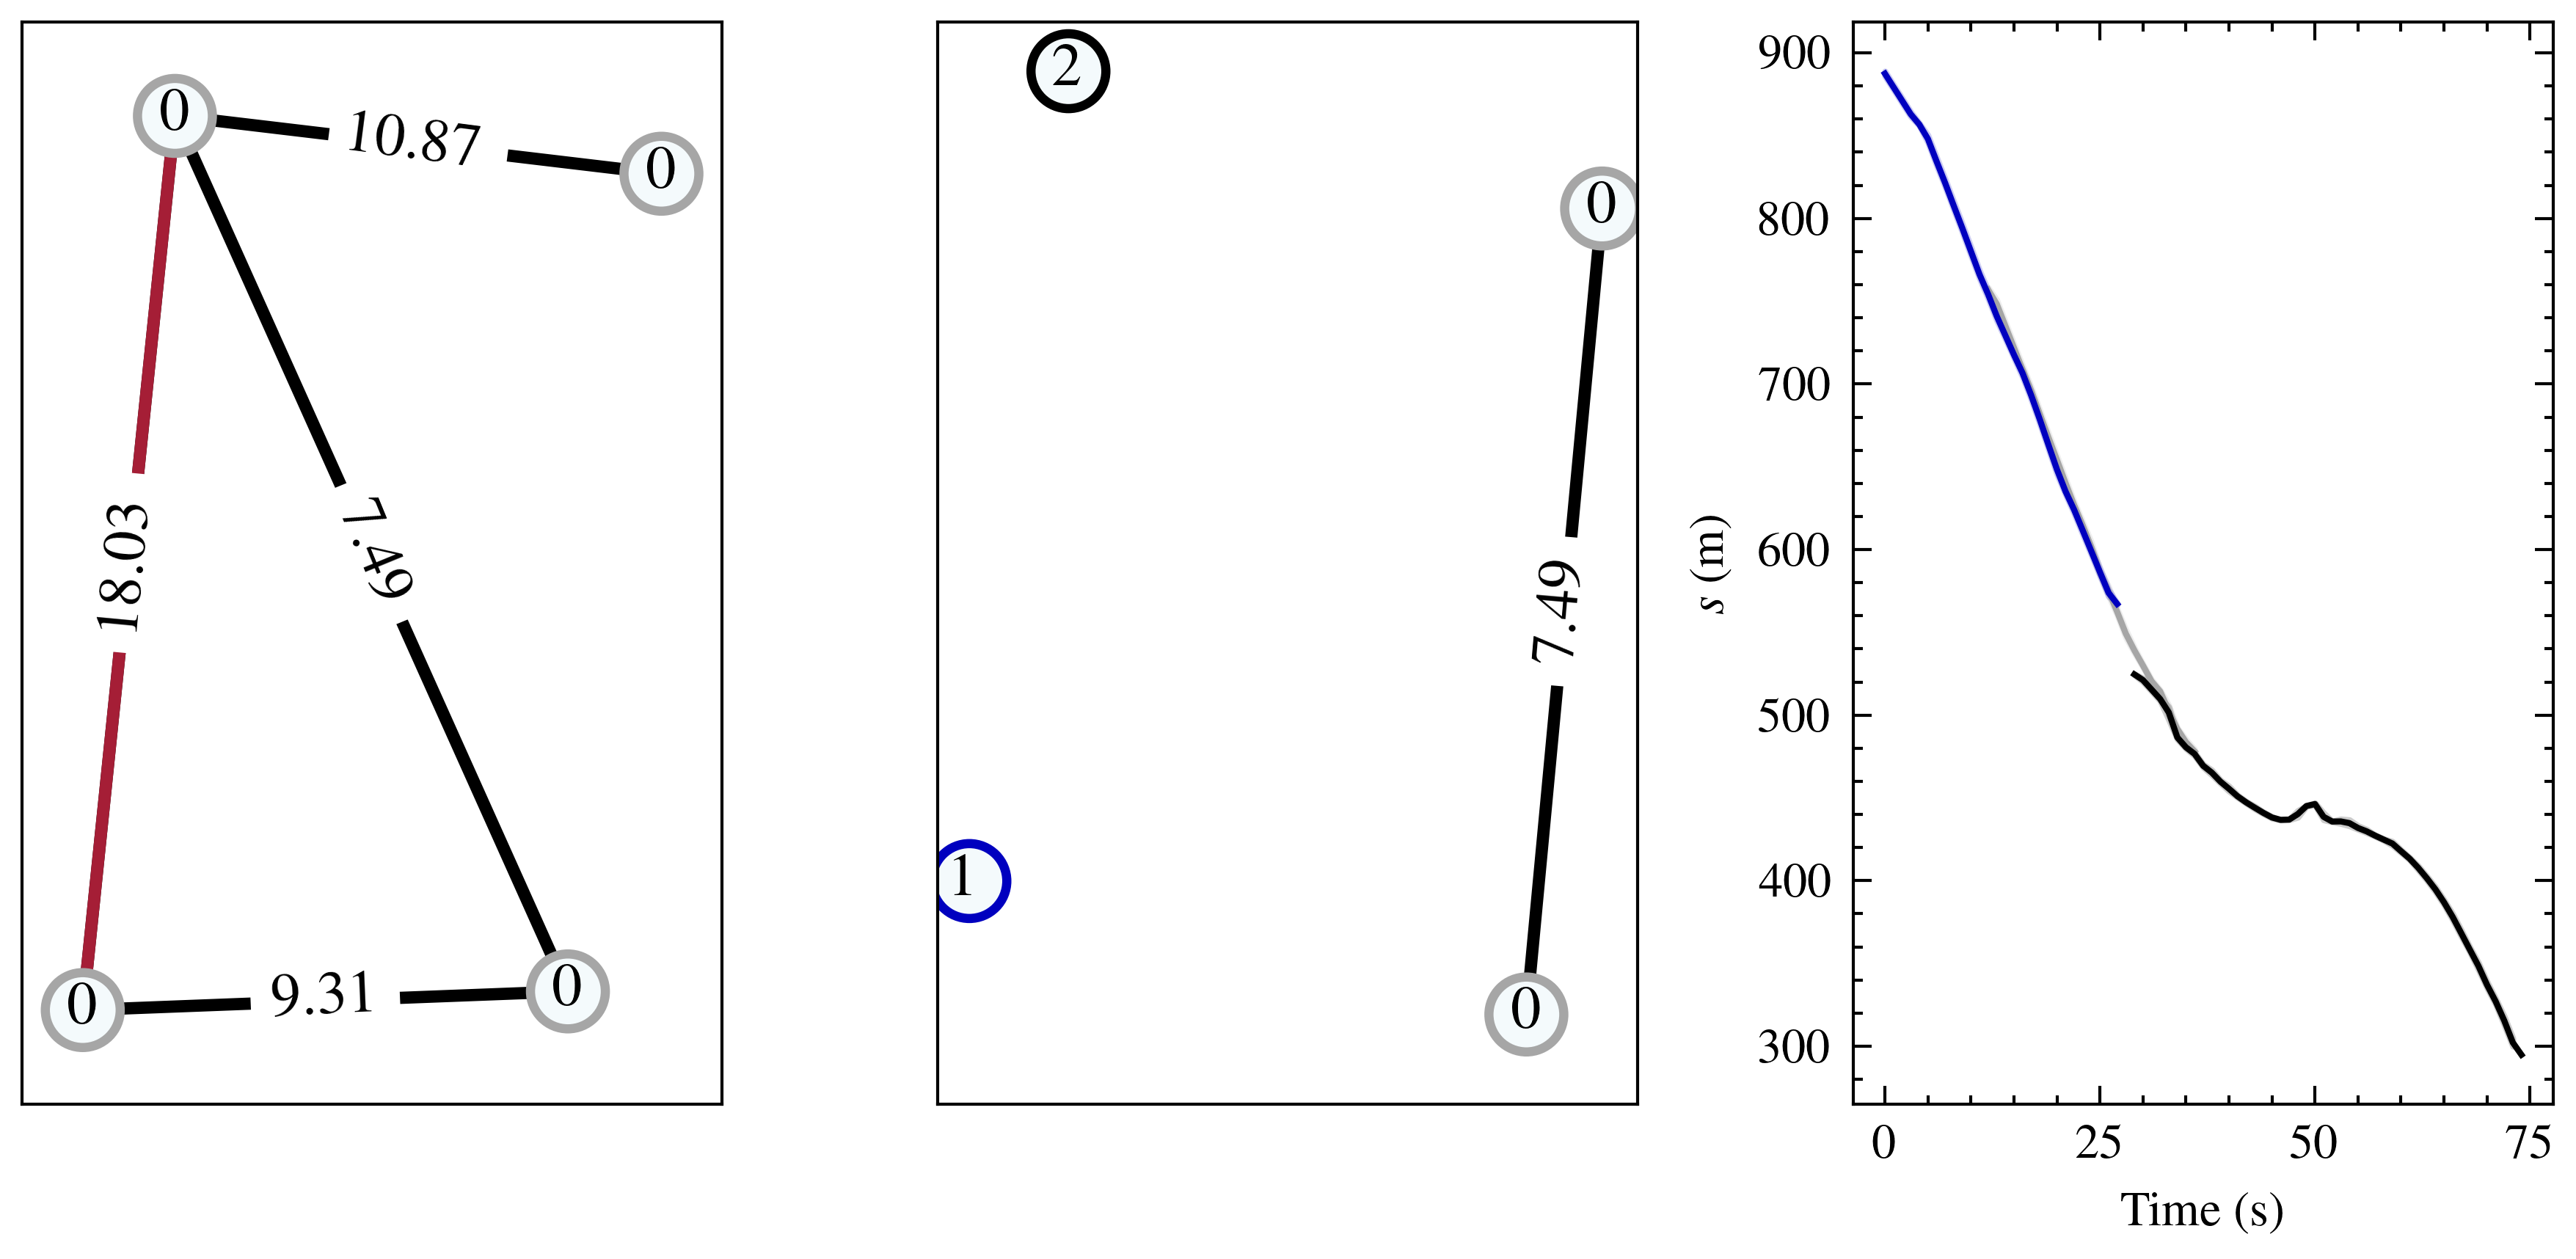

In [57]:
from src.pipelines.association import get_graph_score
from src.plotting.single_veh import plot_graph
import matplotlib.pyplot as plt

engine_color = [0.65, 0.65, 0.65]
gps_color = [0, 0, 0.75]
plutron_color = [0, 0, 0]
# alabama = [165, 30, 54]
# alabama = [i / 255 for i in alabama]

alabama = '#%02x%02x%02x' % (165, 30, 54)


vehicle_id = 303  # use sequence 15 for the example
# vehicle_id = 302
nodes = cc[vehicle_id]

sb_graph = cropped_G.subgraph(nodes)
bad_graph = nx.subgraph_view(bad_edges, filter_node=lambda x: x in sb_graph.nodes)
score = get_graph_score(sub_graph=sb_graph, big_G=big_G, cutoff=chi2.ppf(0.9999, dims))

# make two side by side plots using 
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(6, 3))

# plot the small graph
print(score)
plot_graph(subgraph=sb_graph, full_graph=big_G, ax=ax[0], vehicle_colors=[engine_color, gps_color, plutron_color], bad_edge_color=alabama)

from src.pipelines.association import walk_graph_removals

removal_edges = walk_graph_removals(
    sb_graph.copy(), cutoff=10, max_removals=100, big_G=big_G
)

p_graph = cropped_G.subgraph(nodes).copy()
for edge in removal_edges:
    p_graph.remove_edge(*edge)
plot_graph(subgraph=p_graph, full_graph=big_G, ax=ax[1], vehicle_colors=list(map(lambda x: [x, ], [engine_color, gps_color, plutron_color])), bad_edge_color=[alabama])

# remove the ticks
for a in ax[:-1]:
    a.set_xticks([])
    a.set_yticks([])


# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))
# ax = [ax[-1]]
cc_list = cc[vehicle_id]
# get a 10 minute window
plot_df = joined_df.pipe(radar_obj.add_cst_timezone).join(
    pl.DataFrame(
        [
            (i, v)
            for i, v_list in enumerate(list(nx.connected_components(p_graph)))
            for v in v_list
        ],
        schema={"vehicle_id_new": int, "object_id": pl.UInt64},
    ),
    on="object_id",
).with_columns(
    (pl.col('epoch_time').max() - pl.col('epoch_time')).dt.total_seconds().alias('dt')
)


# plot the trajectories
plot_df = plot_df.to_pandas()

sns.lineplot(
    data=plot_df,
    x="dt",
    y="front_s",
    hue="vehicle_id_new",
    ax=ax[-1],
    legend=False,
    palette=[engine_color, gps_color, plutron_color],
)

# change the labels
ax[-1].set_xlabel("Time (s)")
ax[-1].set_ylabel("$s$ (m)")

# reverse the y-axis
# ax[-1].invert_yaxis()

# drop most of the x ticks 
# ax[0].set_xticks(ax[0].get_xticks()[::1])d
plt.tight_layout()


In [62]:
import plotly.graph_objects as go
from src.plotting.time_space import plot_time_space
from datetime import timedelta


fig = go.Figure()

# get a 10 minute window
plot_df = (
    assoc_df
    # .with_columns(pl.col("").alias("s"))
    .pipe(radar_obj.add_cst_timezone).filter(
        pl.col("epoch_time_cst").is_between(
            pl.lit("2023-10-31 12:13:03").str.strptime(
                pl.Datetime(time_unit="ns", time_zone="US/Central"),
            ),
            pl.lit("2023-10-31 12:14:18").str.strptime(
                pl.Datetime(time_unit="ns", time_zone="US/Central"),
            ),
        )
        & (pl.col("lane").str.contains("W"))
        & (pl.col("lane_index") == 0)
        # & (pl.col('vehicle_id') == 1927)
    )
    # .with_columns(
    #     (pl.col("front_s").max() - pl.col("front_s")).alias("front_s"),
    # )
    # .filter(pl.col("vehicle_id") == 886)
)

fig = plot_time_space(
    plot_df,
    hoverdata="object_id",
    vehicle_col="vehicle_id",
    s_col="front_s",
    markers=True,
    fig=fig,
    every=1,
)

# fig.update_layout(yaxis_autorange="reversed")


fig.show()

function: add_cst_timezone took: 0.0005016326904296875 seconds


In [43]:
from src.pipelines.association import make_graph_based_ids

mainG = G.copy()

# remove_edges = correction_df["remove_edges"].to_list()

for edge in remove_edges:
    mainG.remove_edge(*edge)

new_assoc_df = make_graph_based_ids(assoc_df.drop("vehicle_id"), mainG)

function: lazy_func took: 0.05157923698425293 seconds


In [61]:
import plotly.graph_objects as go
from src.plotting.time_space import plot_time_space
from datetime import timedelta


fig = go.Figure()

# get a 10 minute window
plot_df = (
    new_assoc_df
    # .with_columns(pl.col("").alias("s"))
    .pipe(radar_obj.add_cst_timezone).filter(
        pl.col("epoch_time_cst").is_between(
            pl.lit("2023-10-31 12:13:03").str.strptime(
                pl.Datetime(time_unit="ns", time_zone="US/Central"),
            ),
            pl.lit("2023-10-31 12:14:18").str.strptime(
                pl.Datetime(time_unit="ns", time_zone="US/Central"),
            ),
        )
        & (pl.col("lane").str.contains("W"))
        & (pl.col("lane_index") == 0)
        # & (pl.col('vehicle_id') == 1927)
    )
    # .with_columns(
    #     (pl.col("front_s").max() - pl.col("front_s")).alias("front_s"),
    # )
    # .filter(pl.col("vehicle_id") == 886)
)

fig = plot_time_space(
    plot_df,
    hoverdata="object_id",
    vehicle_col="vehicle_id",
    s_col="front_s",
    markers=True,
    fig=fig,
    every=1,
)

# fig.update_layout(yaxis_autorange="reversed")


fig.show()

function: add_cst_timezone took: 0.0004582405090332031 seconds


## Fuse & Smooth the Trajectories


In [45]:
from src.pipelines.association import build_fusion_df

fusion_df = (
    new_assoc_df.pipe(
        build_fusion_df, prediction_length=prediction_length, max_vehicle_num=3
    )
    .collect(streaming=True)
    .pipe(
        radar_obj.add_cst_timezone,
        time_col="epoch_time",
    )
)
# fusion_df.head()

function: lazy_func took: 2.6707379817962646 seconds
function: add_cst_timezone took: 0.00048065185546875 seconds


In [46]:
# fusion_df.group_by(["vehicle_id", "time_index"]).agg(
#     pl.col("back_s").diff(),
#     pl.col("front_s").diff(),
#     pl.col("s").diff(),
# ).explode(["back_s", "front_s", "s"]).filter(pl.col("back_s").is_not_null())

In [47]:
distance_adjuster = (
    fusion_df.group_by(
        [
            "vehicle_id",
            "time_index",
        ]
    )
    .agg(
        pl.col("distanceToFront_s")
        .filter(pl.col("approaching"))
        .mean()
        .alias("distanceToFront_s"),
        pl.col("distanceToBack_s")
        .filter(~pl.col("approaching"))
        .mean()
        .alias("distanceToBack_s"),
        pl.col("distanceToFront_s").mean().alias("distanceToFront_s_all"),
        pl.col("distanceToBack_s").mean().alias("distanceToBack_s_all"),
    )
    .with_columns(
        pl.when(pl.col("distanceToFront_s").is_null())
        .then(pl.col("distanceToFront_s_all"))
        .otherwise(pl.col("distanceToFront_s"))
        .alias("distanceToFront_s"),
        pl.when(pl.col("distanceToBack_s").is_null())
        .then(pl.col("distanceToBack_s_all"))
        .otherwise(pl.col("distanceToBack_s"))
        .alias("distanceToBack_s"),
    )
    .drop(["distanceToFront_s_all", "distanceToBack_s_all"])
)

In [48]:
outer_df = (
    fusion_df.select(
        [
            "front_s",
            "s",
            "back_s",
            "s_velocity",
            "d",
            "d_velocity",
            "P",
            "vehicle_id",
            "time_index",
            "vehicle_time_index_int",
            "prediction",
            "length_s",
        ]
    )
    .lazy()
    .filter(~pl.col("prediction"))
)

outer_df = (
    (
        outer_df.join(
            outer_df,
            on=["time_index", "vehicle_id"],
            how="outer",
            suffix="_leader",
        )
    )
    .with_columns(
        pl.struct(
            [
                pl.min_horizontal(
                    [
                        pl.col("vehicle_time_index_int"),
                        pl.col("vehicle_time_index_int_leader"),
                    ]
                ).alias("one"),
                pl.max_horizontal(
                    [
                        pl.col("vehicle_time_index_int"),
                        pl.col("vehicle_time_index_int_leader"),
                    ]
                ).alias("two"),
            ]
        ).alias("vehicle_time_struct"),
    )
    # .collect()
    .filter(
        (
            pl.col("vehicle_time_index_int")
            .cum_count()
            .over(["vehicle_id", "time_index", "vehicle_time_struct"])
            < 1
        )
        & (pl.col("vehicle_time_index_int") != pl.col("vehicle_time_index_int_leader"))
    )
    .collect(streaming=True)
    .pipe(
        calc_assoc_liklihood_distance,
        gpu=GPU,
        dims=4,
    )
    .group_by(["vehicle_id", "time_index"])
    .agg(pl.col("association_distance").max())
)

function: lazy_func took: 0.48919105529785156 seconds


In [49]:
prediction_tracker = (
    fusion_df.select(
        [
            "vehicle_id",
            "time_index",
            # "vehicle_time_index_int",
            "prediction",
        ]
    )
    .lazy()
    .group_by(["vehicle_id", "time_index"])
    .agg(pl.col("prediction").all().alias("prediction"))
    .collect()
)

In [50]:
from src.filters.fusion import batch_join, rts_smooth

GPU = True

merged_df = batch_join(
    fusion_df,
    method="ImprovedFastCI",
    batch_size=10_000 if not GPU else 10_000,
    gpu=GPU,
    s_col="front_s" if USE_FRONT else "s",
)
merged_df = rts_smooth(
    merged_df,
    batch_size=10_000 if not GPU else 50_000,
    gpu=GPU,
    s_col="front_s" if USE_FRONT else "s",
)

merged_df = merged_df.drop("lane_index").pipe(
    label_lanes_tree,
    full_network=full_net,
    kalman_network=mainline_net,
    lane_width=LANE_WIDTH,
    s_col="s_smooth",
    d_col="d_smooth",
)


merged_df = (
    merged_df.lazy()
    .join(
        fusion_df.lazy()
        .select(["time_index", "vehicle_id", "object_id", "length_s"])
        .group_by(["time_index", "vehicle_id"])
        .agg(pl.col("object_id"), pl.col("length_s").mean()),
        on=["time_index", "vehicle_id"],
        how="left",
    )
    .join(
        outer_df.lazy().select(["time_index", "vehicle_id", "association_distance"]),
        on=["time_index", "vehicle_id"],
        how="left",
    )
    .join(
        distance_adjuster.lazy(),
        on=["vehicle_id", "time_index"],
        how="left",
    )
    .join(
        prediction_tracker.lazy(),
        on=["vehicle_id", "time_index"],
        how="left",
    )
    .with_columns(
        (pl.col("ci_s") + pl.col("distanceToFront_s")).alias("ci_front_s"),
        (pl.col("ci_s") + pl.col("distanceToBack_s")).alias("ci_back_s"),
        (pl.col("s_smooth") + pl.col("distanceToFront_s")).alias("front_s_smooth"),
        (pl.col("s_smooth") + pl.col("distanceToBack_s")).alias("back_s_smooth"),
    )
    .collect()
)

100%|██████████| 1245/1245 [00:10<00:00, 114.52it/s]
/home/max/Development/roadside-radar/src/filters/fusion.py:1069: UserWarning:

The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)

100%|██████████| 1245/1245 [00:06<00:00, 182.91it/s]


In [51]:
print(joined_df.filter(pl.col("lane_index").is_null()).shape[0] / joined_df.shape[0])

joined_df = joined_df.with_columns(pl.col("lane_index").fill_null(2))

0.0


In [52]:
from src.plotting.single_veh import plot_vehicle

vehs = [1865]

fig = None

for veh in vehs:
    ind_vehicles = fusion_df.filter(pl.col("vehicle_id") == veh)["object_id"].unique()

    fig = plot_vehicle(
        fusion_df.filter(pl.col("vehicle_id") == veh).pipe(radar_obj.add_cst_timezone),
        s_velocity_col="s_velocity",
        s_col="front_s",
        fig=fig,
        data_name="IMM Filtered",
    )

    plot_vehicle(
        merged_df.filter(pl.col("vehicle_id") == veh).pipe(radar_obj.add_cst_timezone),
        # s_col="s_smooth",
        s_col="s_smooth",
        s_velocity_col="s_velocity_smooth",
        # s_velocity_col="ci_s_velocity",
        d_col="d_smooth",
        d_velocity_col="d_velocity_smooth",
        fig=fig,
        color="blue",
        data_name="Fused and Smoothed",
    )

    plot_vehicle(
        merged_df.filter(pl.col("vehicle_id") == veh).pipe(radar_obj.add_cst_timezone),
        # s_col="s_smooth",
        s_col="ci_s",
        s_velocity_col="ci_s_velocity",
        # s_velocity_col="ci_s_velocity",
        d_col="ci_d",
        d_velocity_col="ci_d_velocity",
        fig=fig,
        color="purple",
        data_name="CI Fused",
    )

    plot_vehicle(
        radar_df.filter(
            pl.col("object_id").is_in(
                new_assoc_df.filter(pl.col("vehicle_id") == veh)["object_id"]
            )
            & ~pl.col("prediction")
        ).pipe(
            radar_obj.add_cst_timezone,
        ),
        # s_col="front_s",
        # s_velocity_col="s_velocity",
        d_col="d",
        # d_velocity_col="d_velocity",
        fig=fig,
        color="black",
        data_name="Radar Raw",
    )


fig.update_layout(
    # use journal paper font
    font_family="Times New Roman",
    # set the font size
    font_size=22,
    # update the subplot titles
    title_font_family="Times New Roman",
    title_font_size=44,
    # set the x_limit
    yaxis=dict(
        title="S Distance [m]",
    ),
    yaxis2=dict(
        title="S Velocity [m/s]",
    ),
    yaxis3=dict(
        title="D Distance [m/s]",
    ),
    yaxis4=dict(
        title="D Velocity [m/s]",
    ),
    # set the size of the figure
    width=1000,
    height=600,
    template="ggplot2",
    # set the margin to reduce the whitespace
    margin=dict(l=0, r=0, t=0, b=0),
    # put the legend on the bottom
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        font=dict(
            # family="Times New Roman",
            size=22,
        ),
    ),
)

function: add_cst_timezone took: 0.00018739700317382812 seconds
function: add_cst_timezone took: 0.0001385211944580078 seconds
function: add_cst_timezone took: 6.580352783203125e-05 seconds
function: add_cst_timezone took: 0.0001761913299560547 seconds


### Remap Lane after Filtering

## Save the File

In [53]:
from src.filters.vectorized_kalman import CALCFilter

print(CALCFilter.w_s)

1.4142135623730951


In [54]:
# add x/y as calculated by the Frenet Transform
transformations = [
    ("front_s_smooth", "d_smooth", "front_x_smooth", "front_y_smooth"),
    ("back_s_smooth", "d_smooth", "back_x_smooth", "back_y_smooth"),
    ("s_smooth", "d_smooth", "centroid_x_smooth", "centroid_y_smooth"),
    ("ci_front_s", "ci_d", "ci_front_x", "ci_front_y"),
    ("ci_back_s", "ci_d", "ci_back_x", "ci_back_y"),
    ("ci_s", "ci_d", "ci_centroid_x", "ci_centroid_y"),
]

for s_col, d_col, x_col, y_col in transformations:
    merged_df = (
        merged_df.drop([x_col, y_col])
        .pipe(
            mainline_net.frenet2xy,
            lane_col="lane",
            s_col=s_col,
            d_col=d_col,
        )
        .drop(["s", "angle"])
        .rename({"x_lane": x_col, "y_lane": y_col})
    )

In [55]:
merged_df.drop(*[c for c in merged_df.columns if ("_int" in c)], "ci_P").write_parquet(
    ROOT / "data" / "merged_october_2_meas.parquet",
    use_pyarrow=True,
    compression="zstd",
    compression_level=15,
)

In [56]:
merged_df.filter(pl.col("vehicle_id").is_in([4298, 4313])).drop(
    *[c for c in merged_df.columns if ("_int" in c)], "ci_P"
).write_parquet(
    ROOT / "data" / "traj_samples.parquet",
)